In [1]:
import json
from PIL import Image
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from tqdm.auto import tqdm

from data_utils import(
    load_sugarcrepe,
    coco_cats,
    coco_object_mask,
    filter_coco_distict_objects,
)

from llava_utils import(
    llava_load_model, 
    llava_process_image, 
    llava_generate,
    llava_forward_pass,
)
from lens_utils import(
    llava_logit_lens,
    get_mask_from_lens,
)

##### Constants

In [2]:
# project directory
project_dir = "/root/vlm-compositionality"

# sugarcrepe
dataset_dir = project_dir+'/data/raw/sugarcrepe'

# coco images
image_dir = project_dir+'/data/raw/coco/val2017'
# coco annotations
ann_dir = project_dir+'/data/raw/coco/annotations'
ann_file = ann_dir+'/instances_val2017.json'

# model constants
model_name = "llava-hf/llava-1.5-7b-hf"
logit_topk = 50
mask_topk = 10000
num_patches = 24

##### Load dataset and annotations

In [3]:
# load sugarcrepe
sugarcrepe = load_sugarcrepe(dataset_dir)

# load annotations
coco=COCO(ann_file)

# get coco image ids
image_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!


##### Filter images to get at most one object type per image

In [ ]:
# filter images
image_ids = filter_coco_distict_objects(coco, image_ids)

##### Load model

In [4]:
# load model, processor
model, processor = llava_load_model(model_name) #, flash_attention=False, torch_dtype=torch.float32)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

##### Eval loop

In [5]:
# map image files to F1 scores
# file : {object1: f1_score1, object2: f1_score2,...}
image_to_f1 = {}

# get image, get all object tokens for the image
# for each object token generate logit lens mask and compare with coco mask
bar = tqdm(range(len(image_ids)))
for image_id in image_ids:

    # image info
    image_info = coco.loadImgs(image_id)[0]
    image_file = image_info['file_name']
    image_width = image_info['width']
    image_height = image_info['height']

    # object tokens
    tokens = coco_cats(coco, image_id)

    # get coco masks
    token_to_mask = coco_object_mask(coco, image_id)

    # load image
    image = Image.open(image_dir+'/'+image_file).convert("RGB")

    # process image and prompt(default)
    # prompt does not matter since image tokens do not attend to prompt
    inputs = llava_process_image(image, processor, device=model.device)

    # TODO: why even generate?
    # generate
    #outputs = llava_generate(inputs, model, output_hidden_states=True)

    # forward pass
    outputs = llava_forward_pass(inputs, model, output_hidden_states=True)

    # get logit lens
    # vocab_dim, num_layers, num_tokens
    # TODO: how else to measure overlap other than topk values in mask
    # TODO: what metric other than F1
    softmax_probs = llava_logit_lens(
        inputs,
        model,
        outputs,
        output_type='forward',
        logit_topk=logit_topk,
    )

    # compare for each token
    for token in tokens:
        # get non zero mask from lens
        ll_mask = get_mask_from_lens(
            softmax_probs,
            token,
            processor,
            num_patches,
            image_width,
            image_height,
            mask_type='topk',
            mask_topk=mask_topk,
        )

        # compare coco mask and logit lens mask
        coco_mask = token_to_mask[token]

        # f1 score to estimate overlap
        f1 = f1_score(coco_mask.flatten(), ll_mask.flatten())

        # store f1
        if image_file not in image_to_f1:
            image_to_f1[image_file] = {token: f1}
        else:
            image_to_f1[image_file][token] = f1
        #print("f1 score for {} : {}".format(token, f1))
    #raise
    bar.update(1)

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


f1 score for toilet : 0.1661264792341901
f1 score for sink : 0.5336979433715034


RuntimeError: No active exception to reraise

In [ ]:
image_to_f1

##### Save image to F1 map

In [ ]:
image_to_f1_filename = 'image_to_f1_logit_{}_mask_{}.json'.format(logit_topk, mask_topk)
with open(project_dir+'/data/processed/'+image_to_f1_filename, 'w') as fp:
    json.dump(image_to_f1, fp)

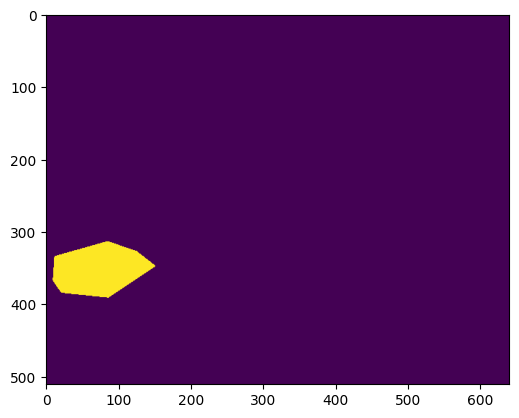

In [6]:
plt.imshow(coco_mask)

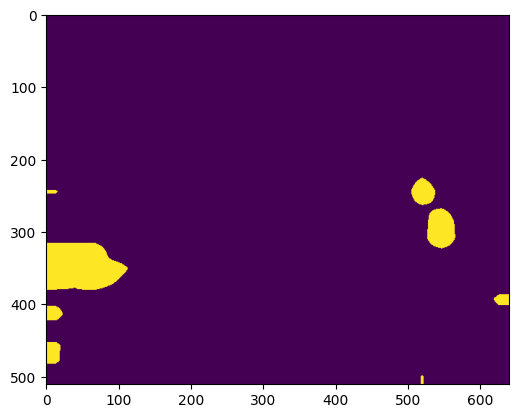

In [7]:
plt.imshow(ll_mask)